# TP noté FAD

Vendredi 25 avril 2025.

A faire en 2h, à remplir et à déposer sur moodle. 

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

# ne pas utiliser de modules supplémentaires

# Option best-of
On considère 2 actifs financiers dont la valeur à l'instant $T > 0$ est modélisée par une loi log-normale c'est à dire
$$
  \forall i \in \{1,2\}, \quad
  S^i_T = S^i_0 \exp\Bigl( \bigl(r-\frac{\sigma_i^2}{2}\bigr) T 
  + \sigma_i \sqrt{T} \tilde G_i \Bigr)
$$
où le vecteur $(\tilde G_1, \tilde G_2)$ est gaussien centré de matrice de covariance $\Sigma = \begin{pmatrix} 1 & \rho \\ \rho & 1\end{pmatrix}$ et les constantes $r > 0$, $\sigma_i > 0$ sont fixées.  

On veut calculer le prix d'un produit financier (une option best-of) c'est à dire calculer
$$
  I_0 = \mathbf{E} \Bigl[ \bigl( \max(S^1_T, S^2_T) - K \bigl)_+ \Bigr],
$$
que l'on propose d'approcher par une méthode de Monte Carlo. Le paramètre $K$ est fixé (globalement) dans la suite à la valeur $K = 100$.

## Question: initialisation
Définir les paramètres globaux $T = 1$, $r = 0.1$, $\sigma_1 = \sigma_2 = 0.2$, $S^1_0 = S^2_0 = 100$ ainsi que $K=100$. 
Le paramètre $\rho$ sera variable et sera donc passé comme argument aux fonctions qui suivent.

In [5]:
T, r = 1, 0.1
sigma = np.full(2, 0.2)
S0 = np.full(2, 100)
K = 100

## Question: simulation
Ecrire une fonction de nom `best_of(size, rho)` qui prend comme argument `rho` la corrélation entre les 2 actifs et qui renvoie un échantillon de taille `size` de réalisations indépendantes de la variable aléatoire $\bigl( \max(S^1_T, S^2_T) - K \bigl)_+$.

In [7]:
def best_of(size, rho):
    d = 2
    correl = np.full((d,d), rho) + (1-rho)*np.eye(d)

    # il'y a des rhos negatifs donc on ne peut pas utiliser .cholesky, instead eigenvalue decomposition:
    eigvals, eigvecs = np.linalg.eigh(correl)
    correl_sqrt = eigvecs @ np.diag(np.sqrt(np.maximum(eigvals, 0))) @ eigvecs.T
    
    sample_G = rng.standard_normal(size=(2, n))
    sample_ST = S0[:,np.newaxis] * np.exp((r-0.5*sigma[:,np.newaxis]**2)* T 
                    + sigma[:,np.newaxis] * np.sqrt(T) * correl_sqrt @ sample_G)
    best_of = np.maximum(0, np.maximum(sample_ST[0],sample_ST[1])-K)
    return best_of

## Question: représentation graphique 
Tester cette fonction en créant un échantillon de taille $n = 10\,000$ et tracer l'histogramme (normalisé) de cet échantillon avec la valeur $\rho = 0.5$.

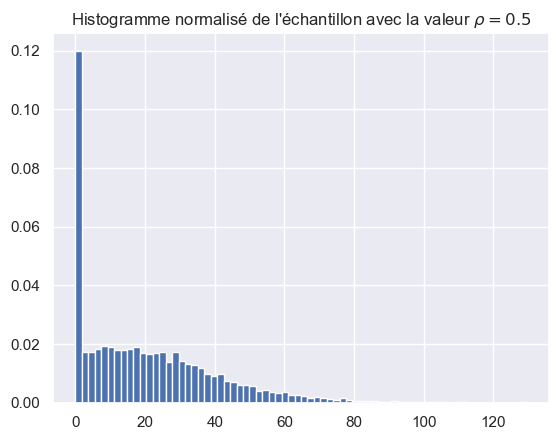

In [9]:
n = int(1e4)
rho = 0.5
best_ofs = best_of(size = n, rho=rho)

fig,ax = plt.subplots()
ax.hist(best_ofs, bins=70,density=True)
ax.set_title(fr"Histogramme normalisé de l'échantillon avec la valeur $\rho = 0.5$")
plt.show()

## Question: estimateur Monte Carlo

Implémenter l'estimateur Monte Carlo $I_n$ de la quantité  $I_0 = \mathbf{E} \Bigl[ \bigl( \max(S^1_T, S^2_T) - K \bigl)_+ \Bigr]$ et donner les résultats (moyenne, variance et IC à 95%) pour différentes valeurs de $\rho \in \{ -1, -0.5, 0, 0.5, 1 \}$. Vous devez afficher un tableau complet des résultats.

Tracer la valeur $I_0$ en fonction de $\rho$ et la zone de confiance à 95%. 

In [11]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    return (mean, var, mean - ci_size, mean + ci_size)

In [12]:
rhos = [-1, -0.5, 0, 0.5, 1]

result = [ monte_carlo(best_of(size = n, rho=rho)) for rho in rhos ]
import pandas as pd
res_df = pd.DataFrame(result, 
                      columns=["mean", "var", "lower", "upper"], 
                      index=rhos)
res_df

,mean,var,lower,upper
-1.0,28.062530,269.839724,27.740571,28.384489
-0.5,26.004549,340.931822,25.642654,26.366443
0.0,23.582874,369.909273,23.205913,23.959834
0.5,21.469716,404.519858,21.075515,21.863918
1.0,14.547016,314.282978,14.199553,14.894479


In [13]:
np.array(result).shape

(5, 4)

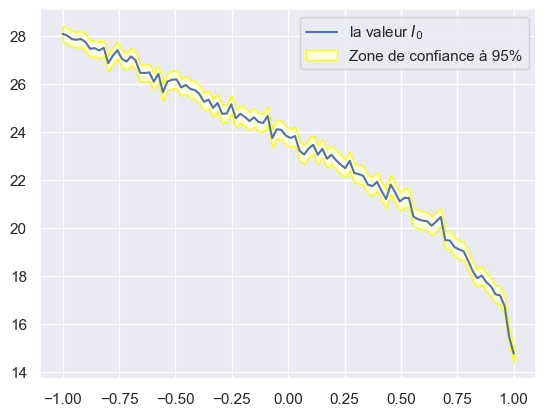

In [14]:
# Tracer la valeur $I_0$ en fonction de $\rho$ et la zone de confiance à 95%. 
xx = np.linspace(-1, 1, 100)
result4plt = np.array([ monte_carlo(best_of(size = n, rho=rho)) for rho in xx ])
yy = result4plt[:, 0]              # take out valeurs I_0 as yy. the size is (100,)
lower = result4plt[:, 2]
upper = result4plt[:, 3]

fig, ax = plt.subplots()
ax.plot(xx, yy, label=fr"la valeur $I_0$")
ax.fill_between(xx, lower, upper, facecolor='lightyellow', 
                edgecolor='yellow', label="Zone de confiance à 95%")
ax.legend()

## Question: variables antithétiques 

Implémenter la méthode des variables antithétiques et calculer les ratios de variance pour différentes valeurs de $\rho$. 

In [16]:
def psi(sample_G, rho): 
    correl = np.full((2,2), rho) + (1-rho)*np.eye(2)                                                       #ou np.diag(np.full(d, 1-rho))
    
    # remplacer methode de Cholesky par eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(correl)
    correl_sqrt = eigvecs @ np.diag(np.sqrt(np.maximum(eigvals, 0))) @ eigvecs.T

    sample_ST = S0[:,np.newaxis] * np.exp((r-0.5*sigma[:,np.newaxis]**2)* T + sigma[:,np.newaxis] * np.sqrt(T) * correl_sqrt @ sample_G)
    return np.maximum(0, np.max(sample_ST, axis=0)-K)

n = int(1e5)
sample_G = rng.standard_normal(size=(2, n))
result = [ monte_carlo(0.5*(psi(sample_G, rho) + psi(-sample_G, rho))) for rho in rhos ]

df_antith = pd.DataFrame(result, 
                         columns=['mean', 'var', 'lower', 'upper'], 
                         index=rhos)
df_antith

,mean,var,lower,upper
-1.0,28.050373,271.544025,27.948240,28.152507
-0.5,25.975888,189.433795,25.890583,26.061194
0.0,23.815506,120.469785,23.747478,23.883534
0.5,21.115161,73.832060,21.061905,21.168417
1.0,14.705070,58.787079,14.657549,14.752592


In [17]:
# le ratio des variances pour les différentes valeurs de rho
res_df["var"] / df_antith["var"]

-1.0    0.993724
-0.5    1.799741
 0.0    3.070556
 0.5    5.478919
 1.0    5.346123
Name: var, dtype: float64

## Question: Monte Carlo adaptatif 

Ecrire une fonction `monte_carlo_adaptatif` qui prend 2 arguments: `epsilon` une valeur qui représente
la précision $\varepsilon > 0$ demandée et `rho` le paramètre de corrélation. Cette fonction implémente un estimateur de Monte Carlo dont le nombre d’itérations $n$ dépend de $\varepsilon$. Plus précisément on veut arrêter l’algorithme lorsque la taille de l’intervalle de confiance à 95% est plus petite que $\varepsilon$.

In [19]:
def monte_carlo_relative(rho, epsilon):
    sample_G = rng.standard_normal(size=(2, 1))
    sample_S = psi(sample_G, rho)
    while True:                                                      # continuer a sampling and update estimateur untill taille < epsilon
        _, _, icg, icd = monte_carlo(sample_S)
        taille = icd - icg
        if taille < epsilon: 
            return sample_S
        else:
            new_sample = psi(sample_G, rho)
            sample_S = np.append(sample_S, new_sample)

# Modèle de Wright-Fisher
Le modèle de Wrigth-Fisher modélise simplement l'évolution de la fréquence d'un allèle dans une population de petite taille fixée égale à $N \ge 0$, pour un gène se présentant sous deux allèles seulement. On considère une population où chaque individu possède un seul exemplaire du gène, sous la forme d'un des deux allèles $A$ ou $B$.

On note $X_n$ le nombre d'allèles $A$ dans la population au temps $n \ge 0$. La suite $(X_n)_{n \ge 0}$ est modélisé par une chaîne de Markov à valeurs dans $E = \{0,1,\dots,N\}$ déterminée par la propriété suivante: la loi de $X_{n+1}$ sachant $X_{n}$ est la loi binomiale $\mathcal{B}(N, X_n / N)$. En d'autres termes, la matrice de transition  $P$ de la chaîne est donnée par
$$
  P(i, j) = \mathbf{P}[X_{n+1} = j | X_n = i] 
  = \binom{N}{j} \bigl(\frac{i}{N}\bigr)^j \bigl(1 - \frac{i}{N} \bigr)^{N-j}.
$$
Il semble intuitif qu'un allèle puisse finir par l'emporter sur l'autre car, si, à un instant $n$, $X_n$ vaut $0$ ou $N$ alors il en sera de même dans tout le futur.

## Question: dynamique 
Ecrire une fonction de nom `phi` qui prend 2 arguments: l'état $x_n \in E$ et la taille $N$ de la population et qui renvoie une réalisation de $X_{n+1}$ selon le modèle ci-dessus. 
**Attention** votre fonction doit être vectorielle et prendre un vecteur d'états `np.array` et renvoyer les états suivants. 

In [22]:
def phi(etat, taille):
    p = etat / taille
    return rng.binomial(taille, p)

## Question: visualisation

Tester cette fonction en affichant 10 trajectoires de la chaine de Markov $(X_n)_{0 \le n \le n_0}$
pour $n_0 = 80$ donné. L'état initial sera $X_0 = 15$ et on prendra $N = 30$ pour les simulations. 

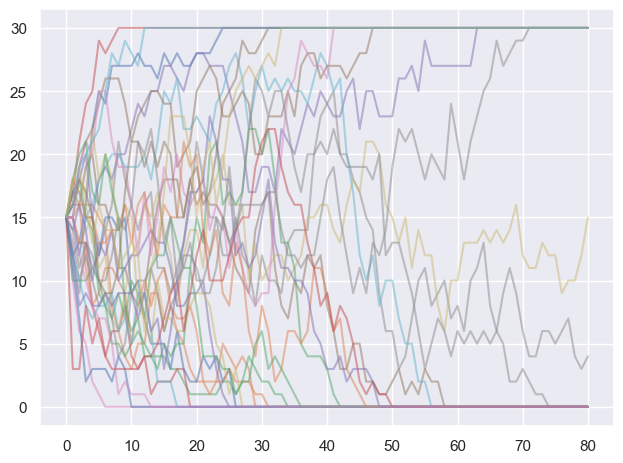

In [24]:
def wf(x0, n0, N):
    sample = np.zeros(shape=(n0+1, N), dtype=np.int64)
    sample[0] = x0
    for k in range(1,n0+1):
        sample[k] = phi(sample[k-1], N)
    return sample.T

x0 = 15
n0 = 80
sample = wf(x0=x0, n0=n0, N=30)
fig, ax = plt.subplots(layout='tight')
for path in sample:           
    ax.plot(path, alpha=0.5)
plt.show()

# it is possible to use **for j, path in enumerate(sample):** to label each trajectoire by **label=f"path{j}"** as it is in TP2.
# but it can be a little bit too crowded for this cas so I deleted it

Les états $0$ et $N$ sont absorbants. Tous les autres mènent à $\{0,N\}$, ils
sont donc transients. L'espace d'états étant fini, le temps d'atteinte de
$\{0,N\}$ est fini presque sûrement et même intégrable. Soit $T$ le temps
d'atteinte de l'ensemble $\{0, N\}$ c'est à dire
$$
  T = \inf\bigl\{n \ge 0, X_n = 0 \; \text{ou} \; X_n = N \bigr\}.
$$

On s'intéresse d'abord à la probabilité d'atteindre l'état absorbant $N$ partant
d'un état initial $i \in E$. On note cette probabilité $p_i$ définie par
$$
  p_i = \mathbf{P} \bigl[ X_T = N \,|\, X_0 = i \bigr].
$$

## Question: événement de sortie en $N$

Programmer une fonction `exit_in_N` qui prend les 2 arguments $i$ et $N$ et qui renvoie vrai si $X_T = N$ et faux si $X_T = 0$. Cette fonction doit être vectorielle: si l'arguments $i$ est un `np.array` le résultat doit être un `np.array` de même taille qui contient des booléens. 

In [27]:
def exit_in_N(i, N):
    i = np.asarray(i)                         # make sure l'arguments est un np.array
    while np.any((i != 0) & (i != N)):        # si any path has not reached to an end, vers l'etat suivant
        i = phi(i, N)
    return i == N

## Question: Monte Carlo sur les probabilités de sortie en $N$ 

Tracer une estimation par Monte Carlo (avec l'intervalle de confiance associé) de $p_i$ en fonction de $i$ pour $i$ parcourant l'espace d'états $\{0,\dots,N\}$ (avec $N = 30$ par exemple). Vous devez trouver la droite 
$i / N$.

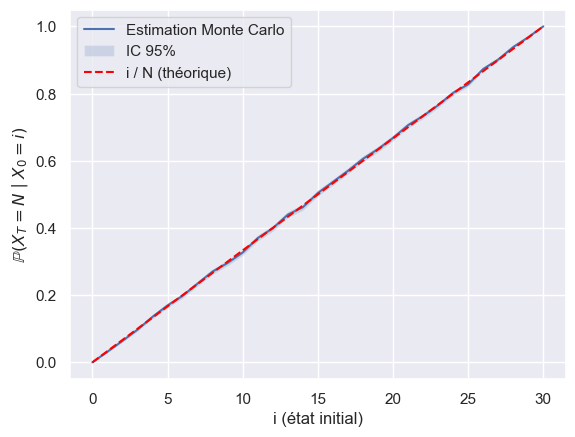

In [29]:
N = 30
p = np.empty(N+1)
icg = np.copy(p)
icd = np.copy(p)
for i in range(N+1):
    ii = np.full(10000,i)
    p[i], _, icg[i], icd[i] = monte_carlo(exit_in_N(ii, N))


x_vals = np.arange(N + 1)
plt.plot(x_vals, p, label="Estimation Monte Carlo")
plt.fill_between(x_vals, icg, icd, alpha=0.2, label="IC 95%")
plt.plot(x_vals, x_vals / N, '--', label="i / N (théorique)", color='red')
plt.xlabel("i (état initial)")
plt.ylabel(r"$\mathbb{P}(X_T = N \mid X_0 = i)$")
plt.legend()
plt.grid(True)
plt.show()

On s'intéresse maintenant au temps moyen de disparition d'un des 2 allèles en partant d'un état $i$ fixé c'est à dire qu'on veut estimer
$$
  m_i = \mathbf{E}\bigl[T \,|\, X_0 = i\bigr].
$$

## Question: temps de sortie en $N$

Programmer une fonction `time_to_exit` qui prend les 2 arguments $i$ et $N$ et qui renvoie une réalisation de $T$ sachant $X_0 = i$. De même cette fonction doit être vectorielle. 

In [32]:
def time_to_exit(i, N):
    i = np.asarray(i)
    t = np.zeros_like(i, dtype=int)
    x = i.copy()
    pas_atteinte = (x > 0) & (x < N)

    while np.any(pas_atteinte):
        x[pas_atteinte] = phi(x[pas_atteinte], N)
        t[pas_atteinte] += 1
        pas_atteinte = (x > 0) & (x < N)
    return t if len(t) > 1 else t[0]

## Question: Monte Carlo sur les temps de sortie en $N$

Tracer une estimation par Monte Carlo (avec l'intervalle de confiance associé) de $m_i$ en fonction de $i$ pour $i$ parcourant l'espace d'états $\{0,\dots,N\}$.

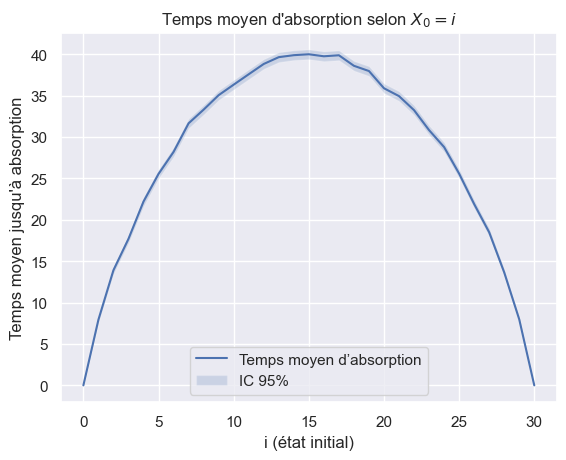

In [34]:
N = 30
m = np.empty(N+1)
icg = np.copy(m)
icd = np.copy(m)
for i in range(N+1):
    ii = np.full(10000,i)
    m[i], _, icg[i], icd[i] = monte_carlo(time_to_exit(ii, N))


x_vals = np.arange(N + 1)
plt.plot(x_vals, m, label="Temps moyen d’absorption")
plt.fill_between(x_vals, icg, icd, alpha=0.2, label="IC 95%")
plt.xlabel("i (état initial)")
plt.ylabel("Temps moyen jusqu'à absorption")
plt.title("Temps moyen d'absorption selon $X_0 = i$")

plt.legend()
plt.grid(True)
plt.show()

# Simulation: Méthode de l'Alias

La méthode de l'alias permet une simulation rapide de lois discrètes à
support fini. Elle utilise la représentation d'une loi donnée $\nu$ à valeurs
dans $\{x_1,\dots,x_n\}$ ($n \ge 1$ fixé), $\nu$ est identifiée à un vecteur
ligne et il existe une matrice stochastique $P$ telle que
\begin{equation*}
  \nu = \mu P \quad \text{où} \quad \mu = \bigl(\frac{1}{n}, \dots, \frac{1}{n} \bigr) \text{ représente la loi uniforme $\mathcal{U}(\{x_1,\dots,x_n\})$.}
\end{equation*}
  
On rappelle qu'une matrice stochastique est une matrice carrée telle que pour
tout $i \in \{1,\dots,n\}$, $\sum_{j=1}^n P(i, j) = 1$, c'est à dire que pour
$i$ fixé $\big(P(i, j)\big)_{j \in \{1,\dots,n\}}$ définit une fonction de masse d'une
probabilité discrète sur $\{x_1,\dots,x_n\}$.

Dans la suite on considère la loi $\nu$ sur $\{1,2,3,4\}$ représentée par le
vecteur ligne $\bigl(\frac{1}{10}, \frac{2}{5}, \frac{1}{5},
\frac{3}{10}\bigr)$.

## Question: simulation et représentation
Créer un échantillon de 1000 réalisations de cette loi discrète $\nu$ et afficher l'histogramme empirique associé et comparer avec la fonction de masse empirique.

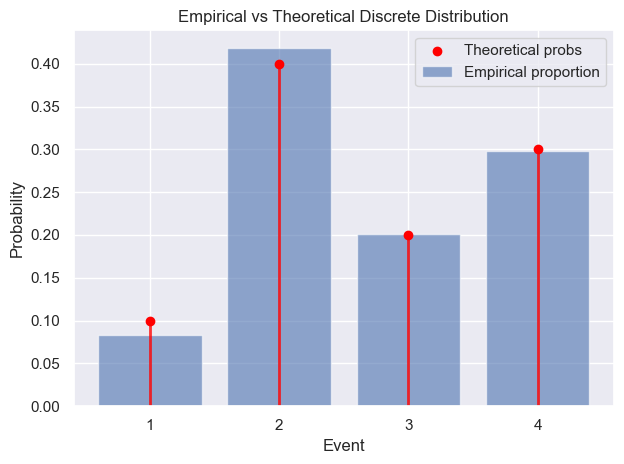

In [37]:
def realization_n(size):
    events = np.arange(1, 5)
    probs = np.array([0.1, 0.4, 0.2, 0.3])
    return np.random.choice(events, size, p=probs)

n, size = 4, 1000
sample_nu = realization_n(size)

support = np.arange(1, n+1)
empirical_prop = np.bincount(sample_nu - 1, minlength=n) / size
true_probs = np.array([0.1, 0.4, 0.2, 0.3])

fig, ax = plt.subplots(layout="tight")
ax.bar(support, empirical_prop, label='Empirical proportion', alpha=0.6)
ax.scatter(support, true_probs, label='Theoretical probs', color='red')
ax.vlines(support, 0, true_probs, color='red', lw=2, alpha=0.8)

ax.set_title('Empirical vs Theoretical Discrete Distribution')
ax.set_xlabel('Event')
ax.set_ylabel('Probability')
ax.set_xticks(support)
ax.legend()
plt.grid(True)
plt.show()

## Question: création 

Voici un algorithme pour construire la matrice stochastique $P$ (faire un dessin pour comprendre l'idée).

* Initialisation: 
  + création de la matrice $P$, matrice diagonale de diagonale $P(i,i) = n
  \nu_i$ (attention ici $P$ n'est pas une matrice stochastique)
  + création des ensembles d'indices $S$ et $L$ définit par 
  $$
  S = \bigl\{1 \le i \le n, P(i,i) < 1 \bigr\} \quad \text{et} \quad 
  L =\bigl\{1 \le i \le n, P(i,i) > 1 \bigr\}
  $$ 
  
* tant que $S$ n'est pas vide 
  + on récupère $i$ un élément (par exemple le premier) de $S$ et $j$ un élément
  de $L$
  + on initialise $P(i,j)$ avec $\delta = 1 - P(i,i)$
  + on corrige la matrice $P$, $P(j,j) = P(j,j) - \delta$
  + on met à jour les ensembles $S$ et $L$: pour cela on utilise la définition
  des ensembles et on enlève de $S$ tous les indices $i$ traités auparavant (que
  l'on peut stocker dans un ensemble $I$ par exemple).

Ecrire une fonction `create_P` qui prend comme argument le vecteur `nu` et qui renvoie la matrice $P$ telle que $\nu = \mu P$.

In [39]:
def create_P(nu):
    nu = np.array(nu)
    n = len(nu)
    P = np.zeros((n, n))
    
    S = []
    L = []

    for i in range(n):
        P[i][i] = n * nu[i]
        if P[i][i] < 1:
            S.append(i)
        elif P[i][i] > 1:
            L.append(i)

    while S:                         # si S n'est pas vide
        i = S.pop(0)  # récupère le premier $i$ de $S$ 
        j = L[0]      # keep it. we cant throw it away yet
        delta = 1 - P[i][i]
        P[i][j] = delta
        P[j][j] -= delta

        if P[j][j] < 1 - 1e-12 and j not in S:
            S.append(j)
        if P[j][j] <= 1 + 1e-12 and j in L:         # until now we can throw it aways
            L.remove(j)

    return P

In [ ]:
nu = np.array([0.1, 0.4, 0.2, 0.3])
P = create_P(nu)
mu = np.ones(4)/4

mu@P

array([0.1, 0.4, 0.2, 0.3])